In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [9]:
# from image_segmentation_functions import Segmenter

# s = Segmenter()

In [17]:
matplotlib.rcParams['image.cmap'] = 'Greys_r'
matplotlib.rcParams['figure.figsize'] = [5,15]

In [3]:
filenames = !ls ./tmp/unlabelled_ones/

In [16]:
imgs = [cv2.imread('./tmp/unlabelled_ones/' + f)[:,:,::-1] for f in filenames]

In [181]:
img = imgs[5]

In [182]:
img,mask = s.process_image(img)

In [24]:
def binarize(img):
    inv = 255 - img
    inv[img==0] = 0
    eroded = cv2.erode(inv,np.ones((5,5)),iterations=5)
    # eroded = cv2.GaussianBlur(eroded,(25,5),5)
    tuned = eroded+img

    # tuned[eroded==0] = 255

    tuned = 255-tuned

    tmp = cv2.medianBlur(
        cv2.erode(tuned,np.ones((1,5)))
        ,5)

    res_img = (tuned.astype('int16') - tmp)

    res_img[(res_img<30)|(eroded==0)] = 0
    
    mask = (
    cv2.dilate(
        cv2.erode(res_img,
                  np.ones((5,1))
                 ),
        np.ones((3,9)), 
        iterations=3
        ) > 0).astype('uint8')
    
    return res_img*mask

def get_lines(im_bin):
    
    histo = cv2.erode(im_bin,np.ones((5,1))).sum(axis=1)
    y = lambda x: histo[x]

    population = np.random.randint(0,len(histo),len(histo))

    pop_size = len(population)-1
    for delta in range(7,0,-1):
        for i in range(100):
            population = list(set([min([max(0,p-delta),p,min(p+delta, pop_size)],key=y) for p in population]))

    population = sorted(list(population))

    for b,e in zip(population[:-1],population[1:]):
        population.append(
            b + max(np.argwhere(histo[b:e] < (histo[b] + 10) ))[0]
        )

    population = sorted(list(population))
    
    return [(b-1,e+1) for b,e in zip(population[:-1], population[1:]) if (70 > e-b > 10) and histo[b:e].mean() > 30]

def shorten_line(line,window_size=8):
    pad_left = window_size // 2
    pad_right = window_size // 2 + window_size % 2
    mf = line[5:15,:].sum(axis=0)
    eroded = np.pad(
        [mf[i:i+8].max() for i in range(mf.shape[0]-8)],
        (pad_left,pad_right),'constant'
    )
    return line[:,np.argwhere(eroded>0).reshape(-1)]

In [25]:
def filter_noise(im_bin):
    tmp = cv2.dilate(
        cv2.medianBlur((im_bin>0).astype('uint8'),5),
        np.ones((5,5))
        )
    s = (tmp.sum(axis=0) > 0)
    s = 2*s - 1
    reg_sizes = list(map(np.sum,
                         np.split(s,
                                  np.argwhere((s[1:]!=s[:-1]))[:,0] + 1)
                        ))
    largest_zone = np.argmax(reg_sizes)
    zeros1 = np.abs(reg_sizes[:largest_zone]).sum()
    zeros2 = np.abs(reg_sizes[largest_zone+1:]).sum()
    im_bin[:,:zeros1] = 0
    im_bin[:,-zeros2:] = 0
    return im_bin

In [185]:
im_bin = binarize(img.astype('uint8'))

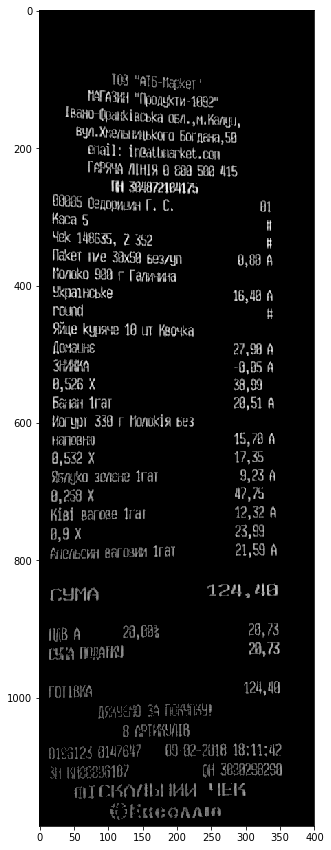

In [186]:
im_bin = filter_noise(im_bin)

plt.imshow(im_bin)

In [43]:
im_bin = cv2.imread('../index.jpeg')[:,:,0]
im_bin = cv2.resize(im_bin,(400,1200))

In [44]:
er_kernel = np.array([[1,1,1],
                      [1,1,1],
                      [1,1,1]],dtype='uint8')

dil_kernel = np.array([[0,0,0,0,0],
                       [0,1,1,1,0],
                       [1,1,1,1,1],
                       [0,1,1,1,0],
                       [0,0,0,0,0]],dtype='uint8')

In [45]:
def close_img(src,dil_kernel,er_kernel,iterations=1):
    res = src.copy()
    for i in range(iterations):
        res = cv2.dilate(res,dil_kernel)
        res = cv2.erode(res,er_kernel)
    return res

In [318]:
def split_into_lines(im_bin):
    
    lines = get_lines(im_bin)
    mask = close_img(im_bin,dil_kernel,er_kernel,iterations=5)
    
    labls,res = cv2.connectedComponents((mask>20).astype('uint8'))

    split = [{'b': l[0],
      'e': l[1],
      'vals': set(np.unique(res[l[0]:l[1]])).difference({0})
     } for l in lines] # which blobs are in which lines
    
    # check how much a blob is in the line
    distr = [{v: (res[s['b']:s['e']] == v).sum() for v in s['vals']} for s in split]
    
    # select the line where the biggest part of the blob belongs
    lbl_lines = {lbl: np.argmax([d.get(lbl, 0) for d in distr]) for lbl in range(1,labls)}

    for i in range(1,labls-1):
        res[res == i] = lbl_lines[i]
        
    return [ ((res == i) * im_bin)[l[0]-5:l[1]+5] for i,l in enumerate(lines)]

In [319]:
%%timeit
im_lines = split_into_lines(im_bin)

339 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


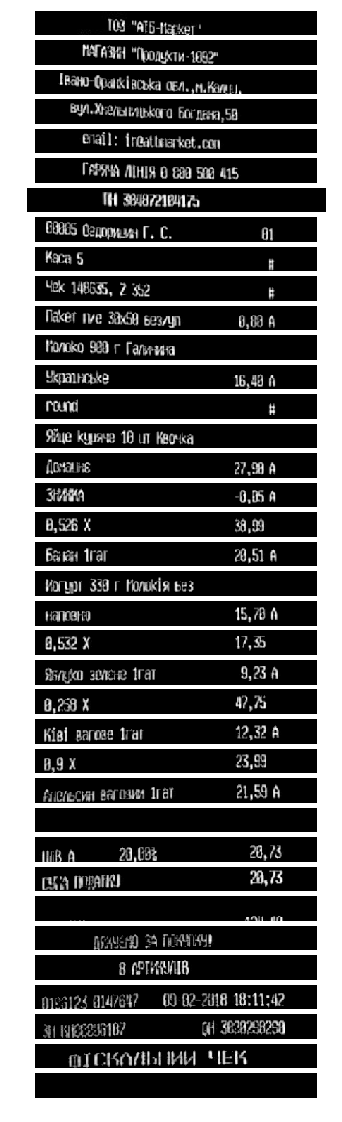

In [334]:
f,ax = plt.subplots(len(im_lines),1,figsize=(15,20))
for a,l in zip(ax,im_lines):
    a.imshow(l[:35,:])
    a.axis('off')
    
plt.subplots_adjust(left=0)

In [276]:
res == 1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [268]:
np.s_[2:4]

slice(2, 4, None)

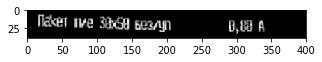

In [260]:
plt.imshow(((res == 10) * im_bin)[345:385])

In [216]:
tmp = im_bin.copy()

In [217]:
tmp[res != 12] = 0

(-0.5, 399.5, 1199.5, -0.5)

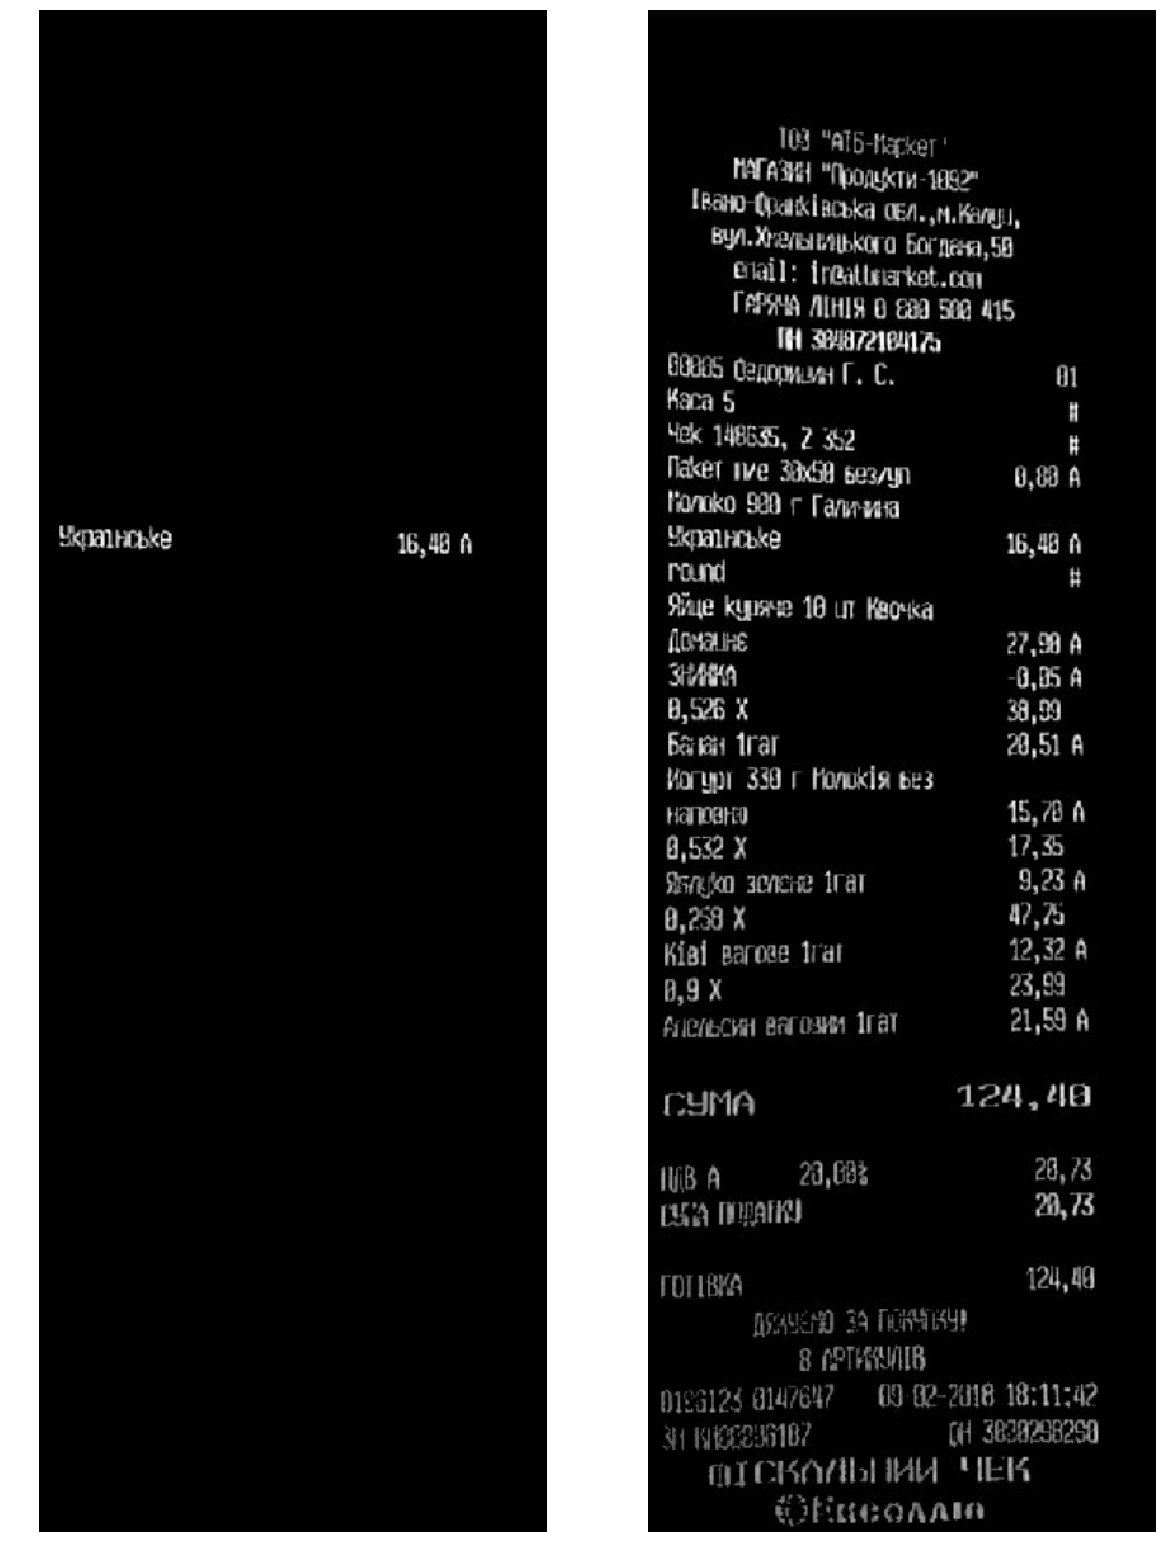

In [218]:
f,ax = plt.subplots(1,2,figsize=(20,30))
ax[0].imshow(tmp)
ax[0].axis('off')
ax[1].imshow(im_bin)
ax[1].axis('off')

In [193]:
beg_end_l = get_lines(im_bin[:,:200])
beg_end_r = get_lines(im_bin[:,200:])

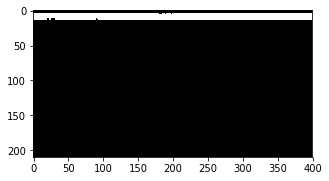

In [230]:
mask = np.zeros_like(tmp)

mask[5:14] = 1

plt.imshow((tmp == 0) & mask )

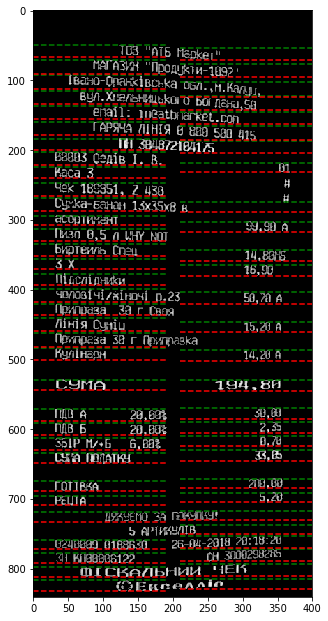

In [167]:
plt.imshow(im_bin)
plt.hlines([x[0] for x in beg_end_l],0,190,color='g',linestyle='--')
plt.hlines([x[1] for x in beg_end_l],0,190,color='r',linestyle='--')

plt.hlines([x[0] for x in beg_end_r],210,399,color='g',linestyle='--')
plt.hlines([x[1] for x in beg_end_r],210,399,color='r',linestyle='--')

In [55]:
lines = [im_bin[x[0]:x[1],:] for x in beg_end]

In [56]:
tmp = [l.sum(axis=0) for l in lines]

In [67]:
mask_nok = np.zeros_like(tmp[0])

In [75]:
mask_nok[100:300] = 1

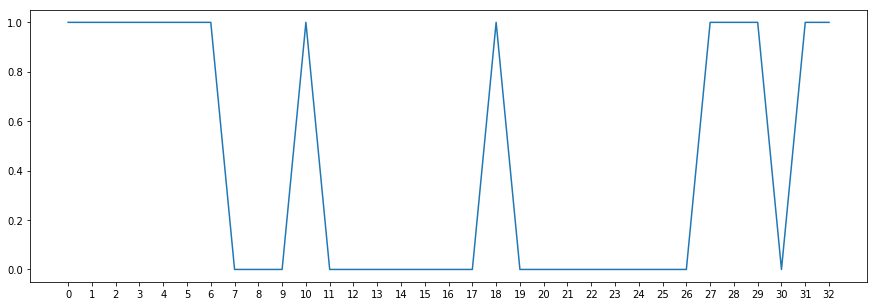

In [83]:
plt.figure(figsize=(15,5))
plt.plot( [(mask_nok * l).sum() > ((1-mask_nok) * l).sum() for l in tmp])
plt.xticks(range(len(tmp)))
plt.show()

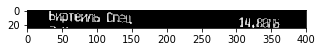

In [91]:
plt.imshow(lines[12])

In [ ]:
from scipy.signal import gaussian

In [ ]:
plt.figure(figsize=(15,5))
plt.plot([ (gaussian(341,50) * l).sum() for l in tmp])
plt.plot([ (gaussian(100,30) * l[:100] + gaussian(100,30) * l[-100:]).sum() for l in tmp])

In [ ]:
(tmp[0] > 0).astype('uint8')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.r_[[l.sum(axis=0) for l in lines]])

In [ ]:
zone1 = reg_sizes[:2]

In [ ]:
inv = 255 - img
inv[img==0] = 0
eroded = cv2.erode(inv,np.ones((5,5)),iterations=5)
# eroded = cv2.GaussianBlur(eroded,(25,5),5)
tuned = eroded+img

# tuned[eroded==0] = 255

tuned = 255-tuned

tmp = cv2.medianBlur(
    cv2.erode(tuned,np.ones((1,5)))
    ,5)

res_img = (tuned.astype('int16') - tmp)

res_img[res_img<30] = 0

f,ax = plt.subplots(2,2,figsize=(10,20))
[x.axis('off') for x in ax.ravel()]
ax[0,0].imshow(inv[:-100,:])
ax[0,0].set_title("original inverted")
ax[0,1].imshow(eroded[:-100,:])
ax[0,1].set_title("erosion")
ax[1,0].imshow(tmp[:-100,:])
ax[1,0].set_title("median blur")
ax[1,1].imshow(res_img[:-100,:]*(eroded[:-100,:]>0).astype('uint8'))
ax[1,1].set_title("result")

In [ ]:
thresh = (res_img>30).astype('uint8')
dil = cv2.dilate(thresh,np.ones((1,5)),iterations=5)
erod = cv2.erode(dil,np.ones((3,1)),iterations=2)
f,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(erod.sum(axis=1))

In [ ]:
histo = erod.sum(axis=1)*0.5 + res_img.sum(axis=1)*0.5
y = lambda x: histo[x]

population = np.random.randint(0,len(histo),len(histo))

pop_size = len(population)-1
for delta in range(7,0,-1):
    for i in range(100):
        population = set([min([max(0,p-delta),p,min(p+delta, pop_size)],key=y) for p in population])

population = sorted(list(population))

for i,j in zip(population[:-1],population[1:]):
    if (j-i) < 10:
        if i in population and j in population:
            population.remove(max([i,j],key=y))

In [ ]:
widths = np.r_[population[1:]] - np.r_[population[:-1]]

bar_center = np.r_[population[:-1]]+widths//2

In [ ]:
f,ax = plt.subplots(2,1,figsize=(15,15)) #,sharex=True)
ax[0].plot(histo)
ax[0].scatter(population,[y(x) for x in population],c='r')
ax[0].bar(bar_center,widths*100,width=widths,color='k',alpha=0.1)
ax[0].hlines([np.mean(widths)*100],0,len(histo),color='k')

ax[1].imshow(res_img.T)
ax[1].vlines(population,0,299,color='r')
ax[1].set_ylim(0,300)
ax[1].set_xlim(0,len(histo))
print("done")

In [ ]:
center = bar_center[13]
line = res_img[center-10:center+10,:] 

f,ax = plt.subplots(2,1,figsize=(15,3))
thresh = (line>20).astype('uint8')
close = cv2.morphologyEx(thresh[5:15,:],cv2.MORPH_CLOSE,np.ones((45,5)))
ax[0].imshow(close)

ax[1].imshow(line)
lims = np.argwhere(close[0,:-1] - close[0,1:])[:,0]
begs = lims[::2]
ends = lims[1::2]+1
mask = (ends - begs) > 5
begs = begs[mask]
ends = ends[mask]
ax[1].vlines(begs,0,19,color='b')
ax[1].vlines(ends,0,19,color='r')